In [1]:
import numpy as np

%matplotlib inline

In [18]:
data = np.load('data/electrons_log', encoding='latin1')
real_data = np.exp(data)
real_data_mean = real_data.mean(axis=0)
real_data_std = real_data.std(axis=0)
stand_real_data = np.divide(real_data - real_data_mean, real_data_std, where = (real_data - real_data_mean) != 0)

In [19]:
tanh_data = np.tanh(data)

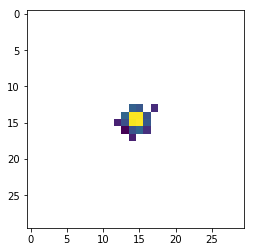

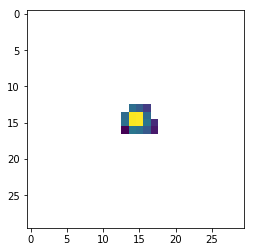

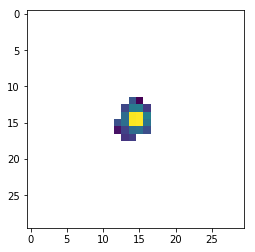

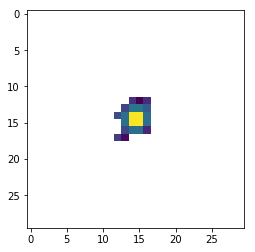

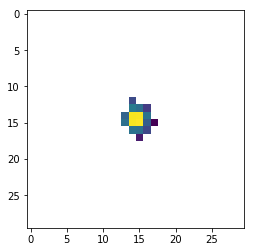

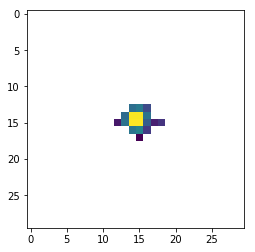

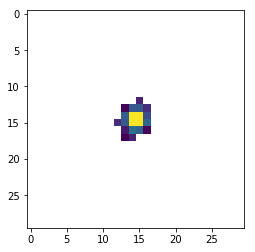

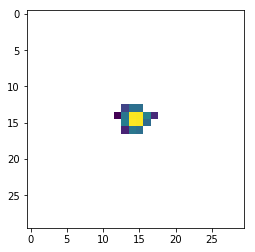

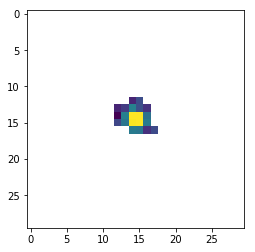

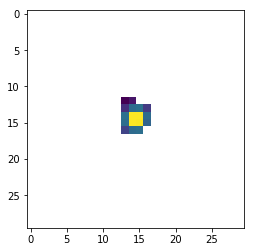

In [3]:
import scipy.misc
import matplotlib.pyplot as plt

%matplotlib inline

for i in range(10):
    plt.figure()
    plt.imshow(data[i])

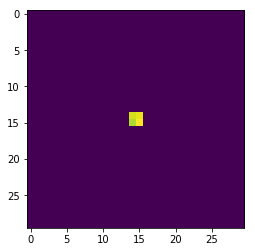

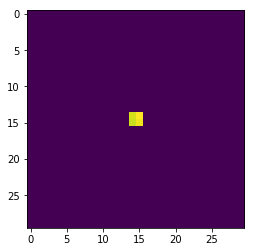

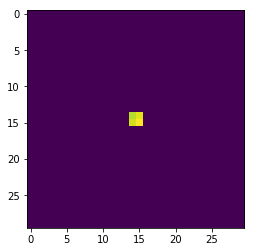

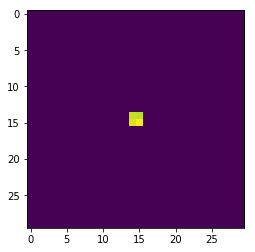

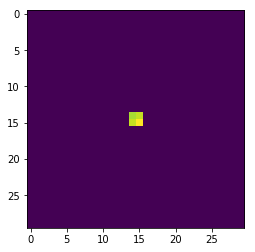

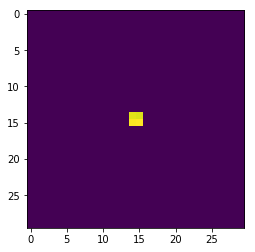

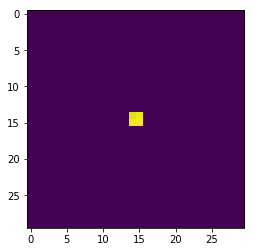

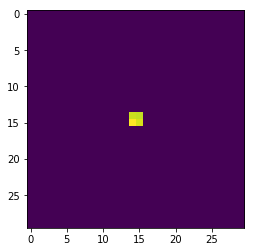

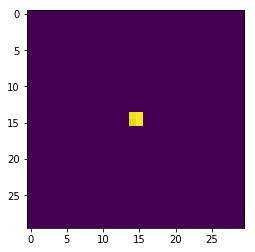

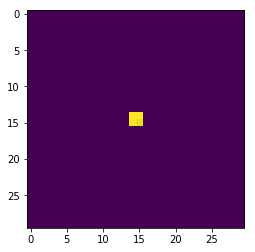

In [4]:
for i in range(10):
    plt.figure()
    plt.imshow(real_data[i])

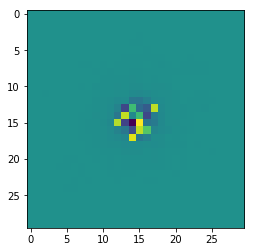

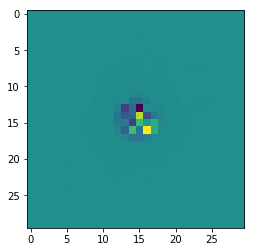

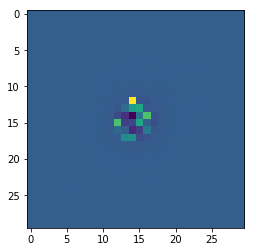

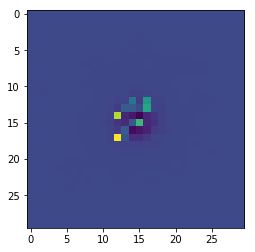

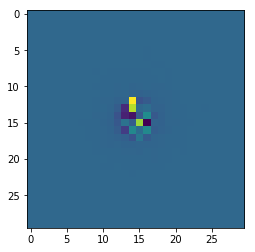

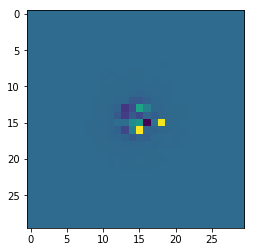

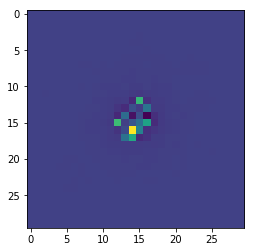

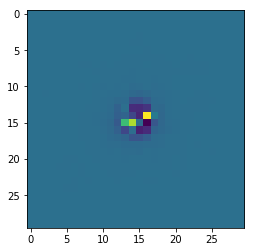

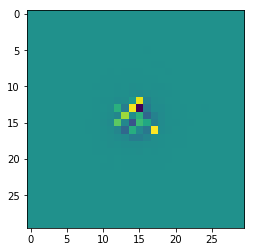

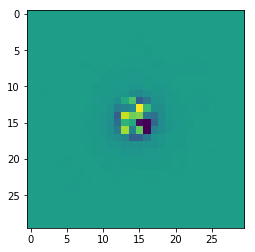

In [5]:
for i in range(10):
    plt.figure()
    plt.imshow(stand_real_data[i])

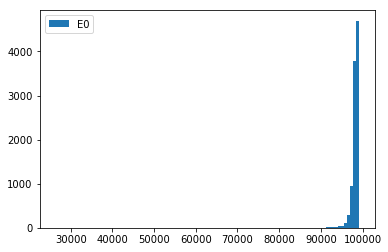

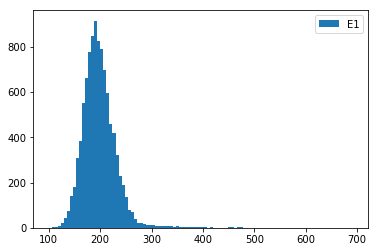

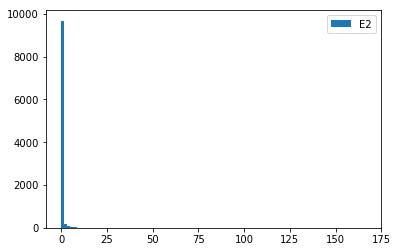

In [6]:
E, E_first, E_second = np.zeros(10000), np.zeros(10000), np.zeros(10000)

for i in range(10000):
    E[i] = np.exp(data[i][14][14]) +  np.exp(data[i][15][14]) + np.exp(data[i][14][15]) + np.exp(data[i][15][15])
    for j in range(4):
        for k in range(4):
            if (j == 0 or j == 3 or k == 0 or k == 3):
                 E_first[i] += np.exp(data[i][13+j][13+k])
            if (j == 0 or j == 7 or k == 0 or k == 7):
                 E_second[i] += np.exp(data[i][11+j][11+k])
                    
plt.hist(E, 100, label='E0')
plt.legend(loc='best')
plt.show()
plt.hist(E_first, 100, label='E1')
plt.legend(loc='best')
plt.show()
plt.hist(E_second, 100, label='E2')
plt.legend(loc='best')
plt.show()

In [7]:
from IPython import display
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.layers import Conv2D

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


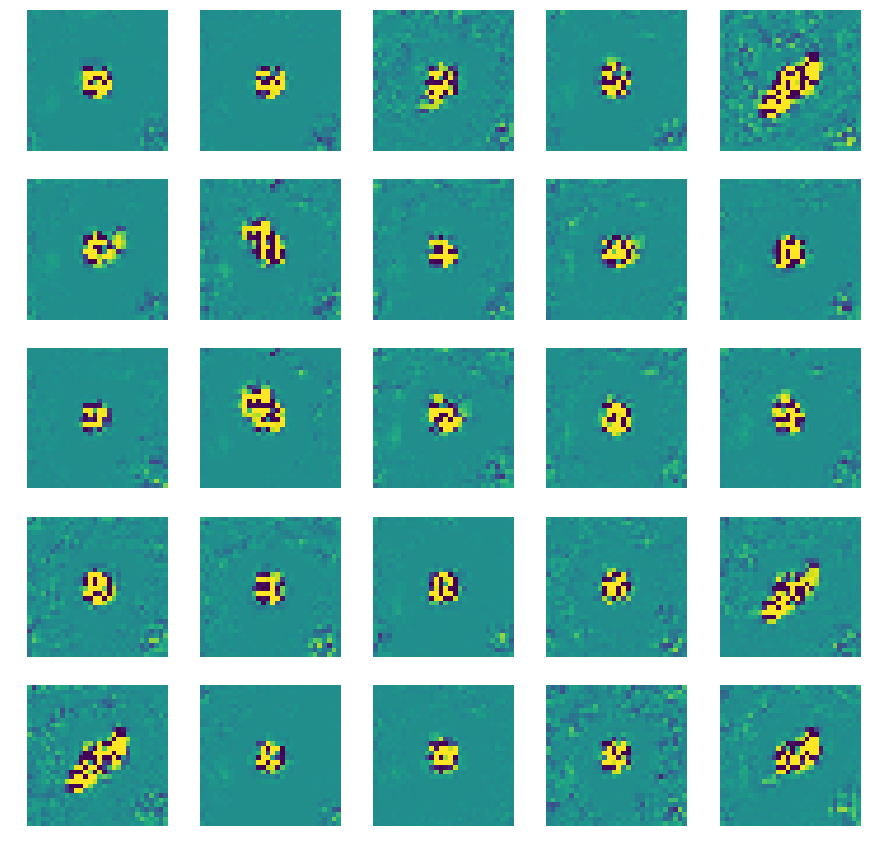

In [9]:
class WGAN():
    def __init__(self):
        self.img_rows = 30
        self.img_cols = 30
        self.channels = 1

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(128 * 15 * 15, activation="relu", input_shape=noise_shape))
        model.add(Reshape((15, 15, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

#        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
#        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3,padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(MaxPooling2D((2, 2)))
#        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
#        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(MaxPooling2D((2, 2)))
#        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(256))

#        model.summary()

        img = Input(shape=img_shape)
        features = model(img)
        valid = Dense(1, activation="linear")(features)

        return Model(img, valid)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Rescale -1 to 1
        X_train = stand_real_data
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (half_batch, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, -np.ones((half_batch, 1)))
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.ones((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip discriminator weights
                for l in self.discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, -np.ones((batch_size, 1)))

            # Plot the progress
#            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
    def sample_images(self, epoch):
        display.clear_output()
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
#        plt.close()


if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=4000, batch_size=32, sample_interval=50)

In [8]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, InputLayer, AveragePooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.layers import Conv2D, Deconv2D

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

In [9]:
import tensorflow as tf

In [10]:
noise_shape = (100, )
img_shape = (30, 30, 1)
K.set_learning_phase(1)
leak_slope = 0.3

In [13]:
2+2

4

In [14]:
tanh_data = np.tanh(data)

epoch 0


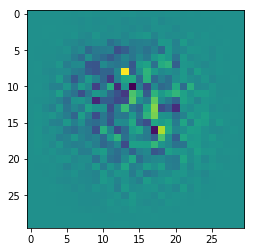

epoch 50


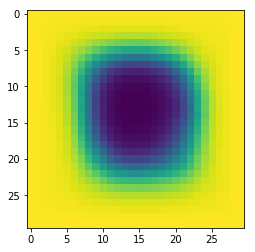

epoch 100


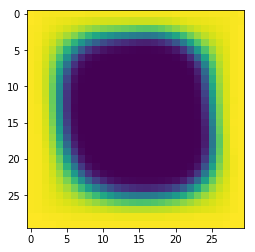

epoch 150


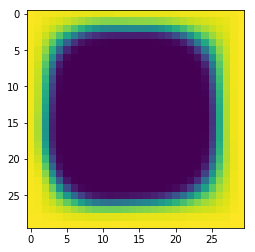

epoch 200


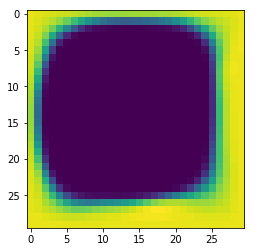

epoch 250


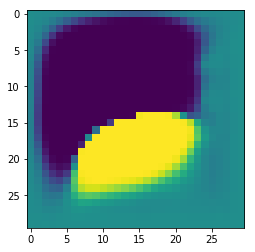

epoch 300


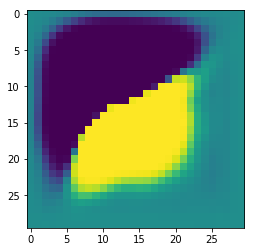

epoch 350


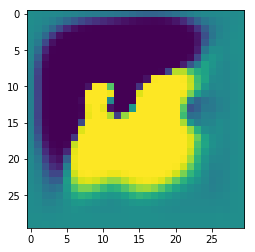

epoch 400


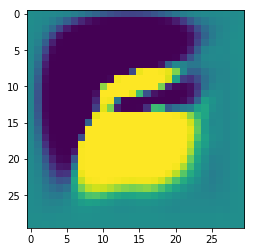

epoch 450


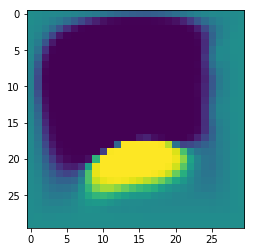

epoch 500


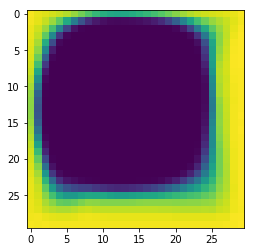

epoch 550


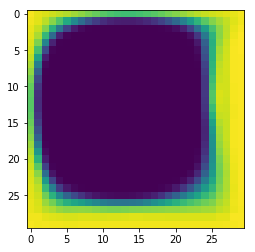

epoch 600


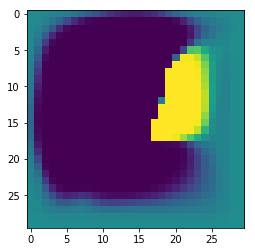

epoch 650


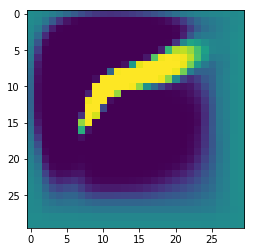

epoch 700


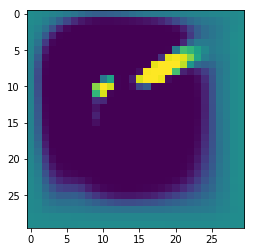

epoch 750


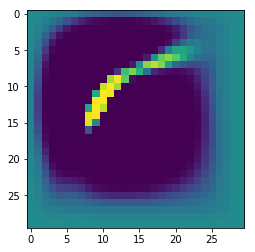

epoch 800


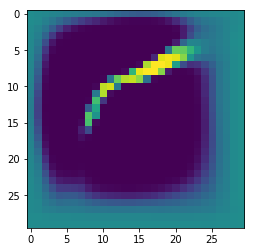

epoch 850


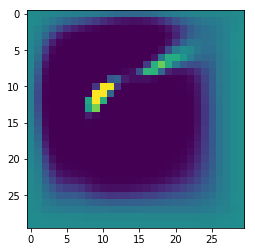

epoch 900


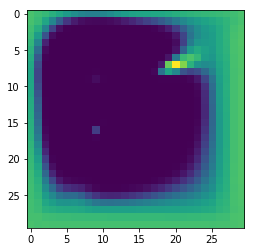

epoch 950


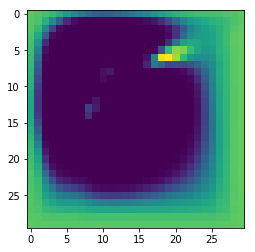

epoch 1000


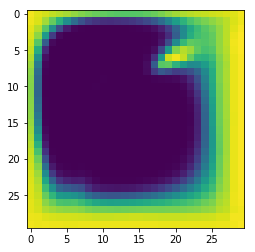

epoch 1050


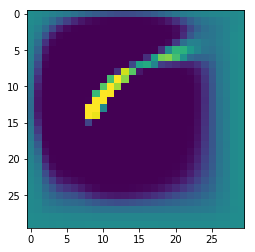

epoch 1100


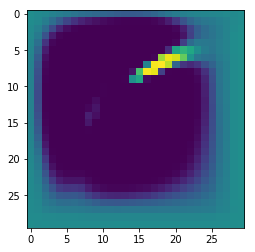

epoch 1150


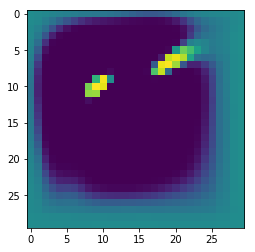

epoch 1200


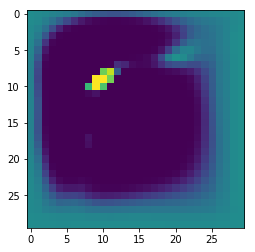

epoch 1250


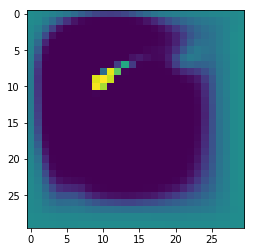

epoch 1300


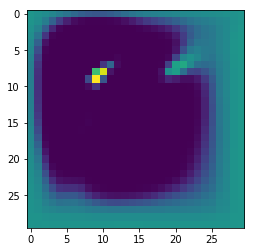

epoch 1350


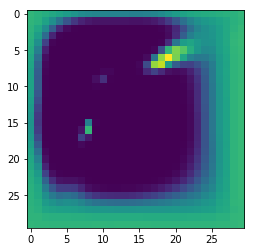

epoch 1400


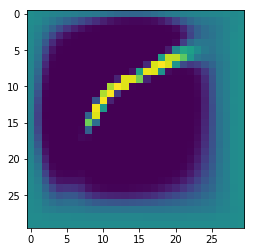

epoch 1450


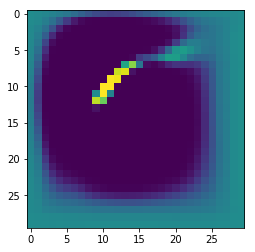

epoch 1500


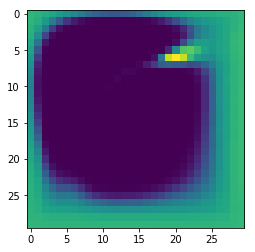

epoch 1550


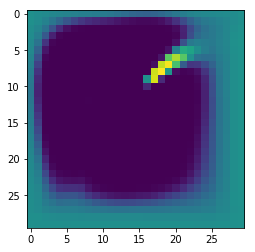

epoch 1600


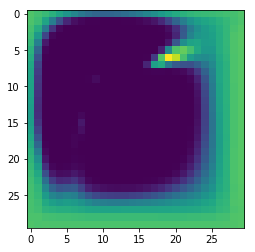

epoch 1650


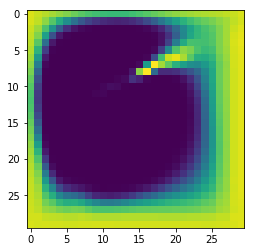

epoch 1700


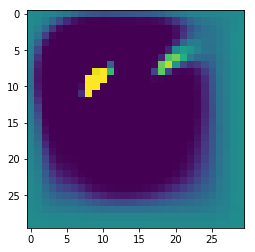

epoch 1750


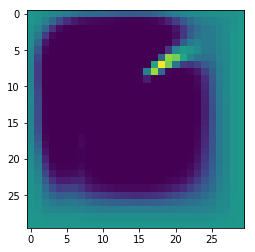

epoch 1800


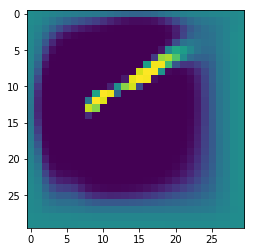

epoch 1850


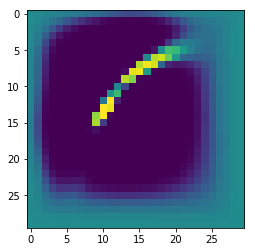

epoch 1900


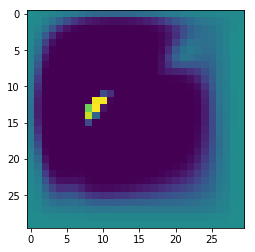

epoch 1950


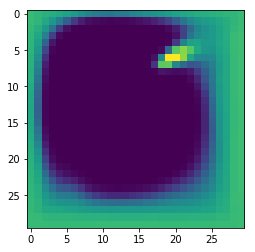

epoch 2000


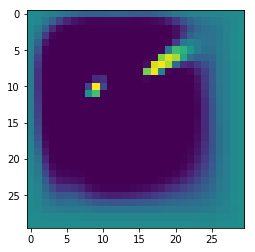

epoch 2050


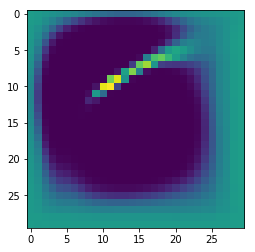

epoch 2100


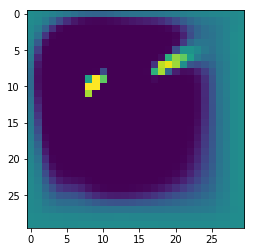

epoch 2150


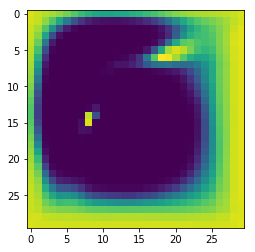

epoch 2200


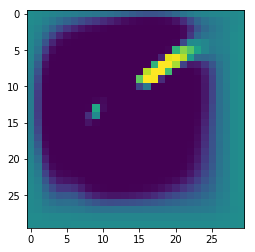

epoch 2250


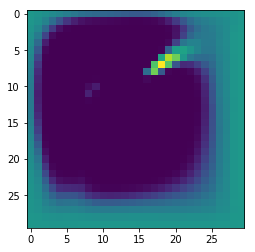

epoch 2300


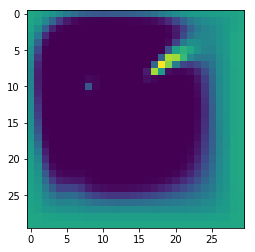

epoch 2350


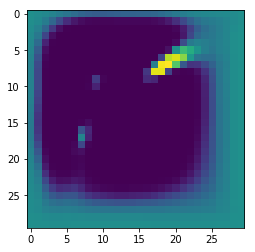

epoch 2400


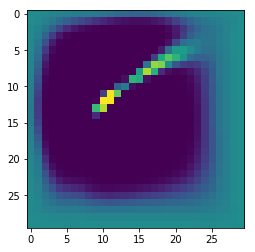

epoch 2450


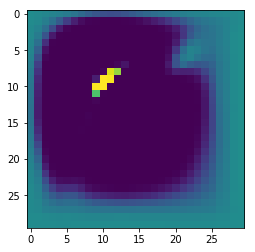

epoch 2500


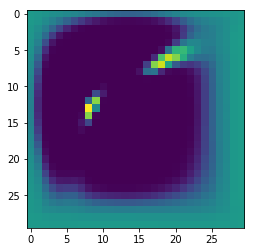

epoch 2550


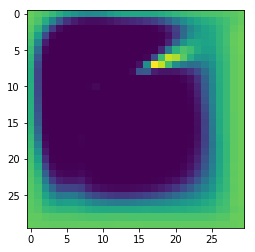

epoch 2600


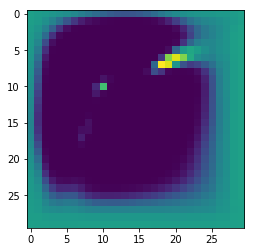

epoch 2650


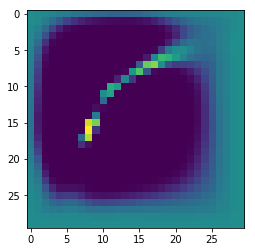

epoch 2700


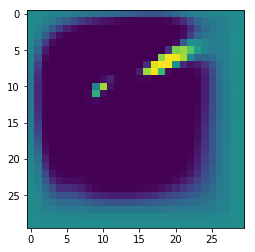

epoch 2750


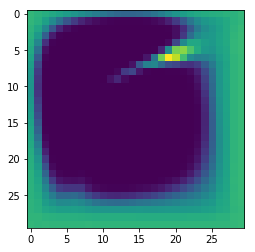

epoch 2800


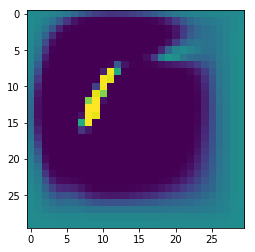

epoch 2850


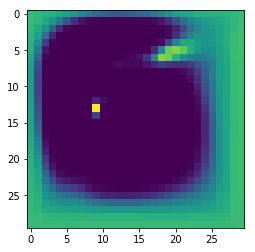

epoch 2900


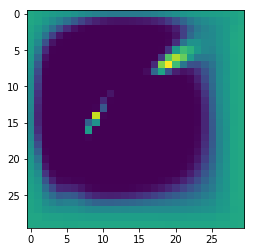

epoch 2950


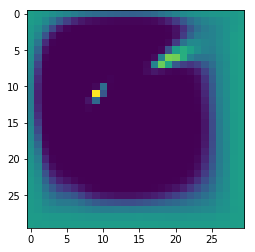

epoch 3000


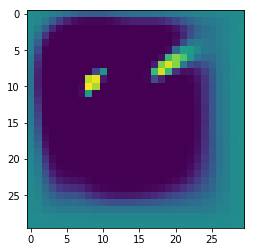

epoch 3050


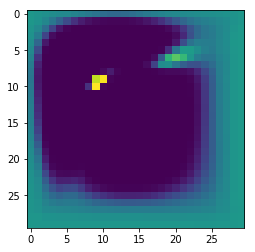

epoch 3100


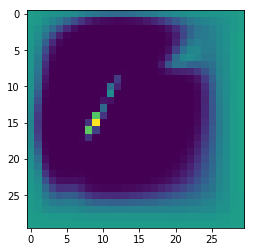

epoch 3150


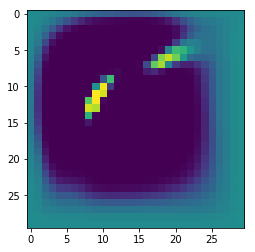

epoch 3200


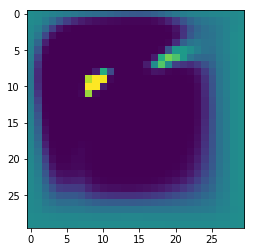

epoch 3250


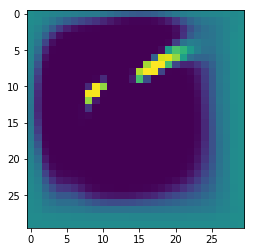

epoch 3300


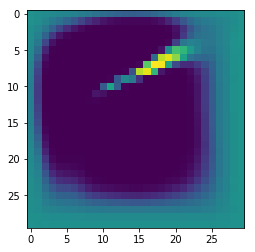

epoch 3350


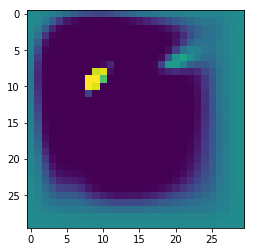

epoch 3400


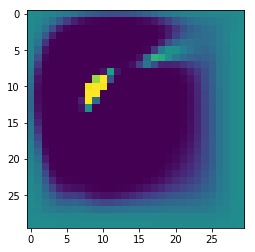

epoch 3450


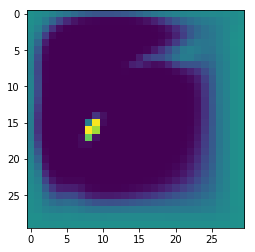

epoch 3500


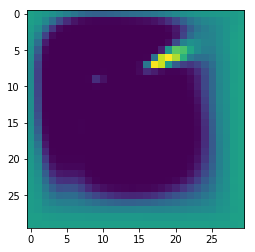

epoch 3550


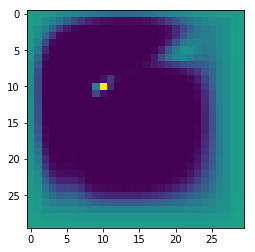

epoch 3600


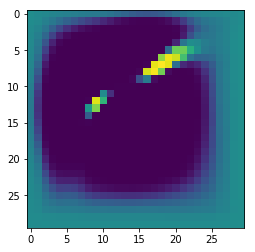

epoch 3650


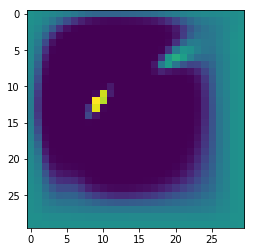

epoch 3700


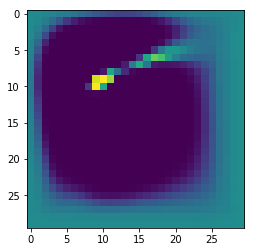

epoch 3750


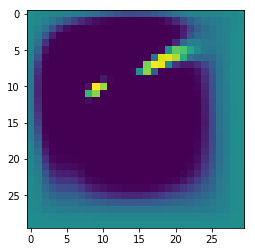

epoch 3800


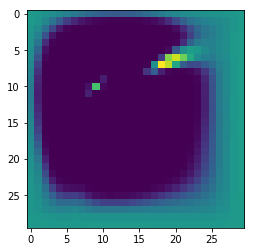

epoch 3850


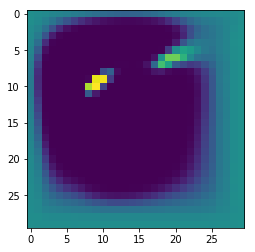

epoch 3900


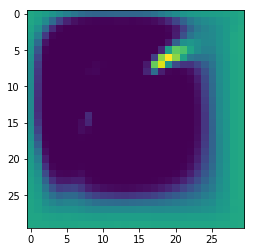

epoch 3950


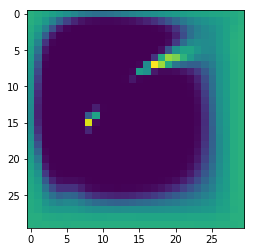

epoch 4000


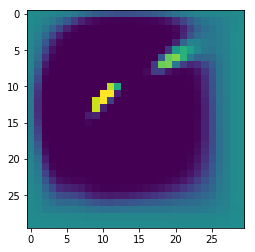

epoch 4050


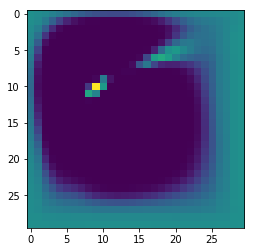

epoch 4100


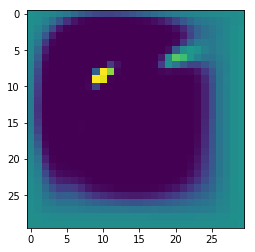

epoch 4150


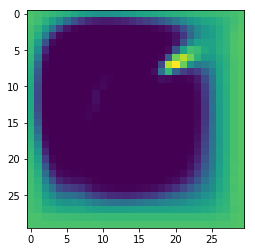

epoch 4200


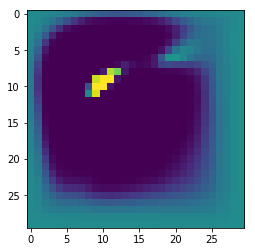

epoch 4250


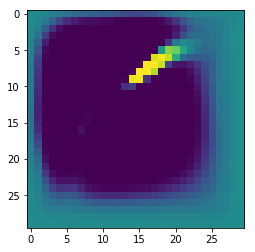

epoch 4300


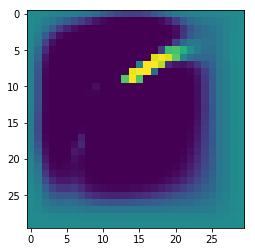

epoch 4350


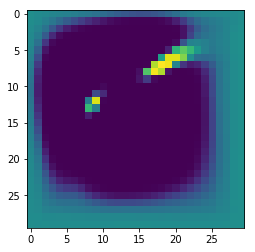

epoch 4400


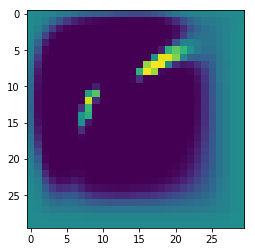

epoch 4450


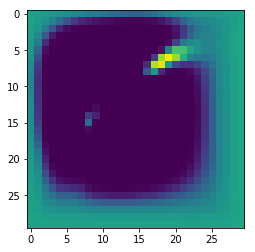

epoch 4500


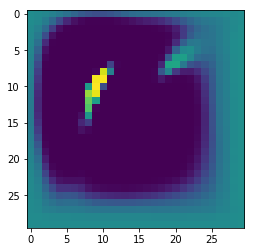

epoch 4550


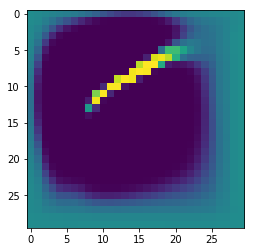

epoch 4600


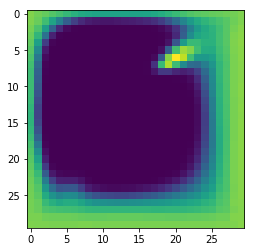

epoch 4650


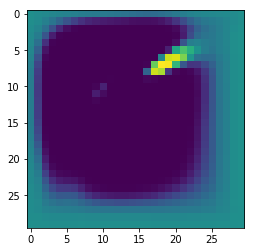

epoch 4700


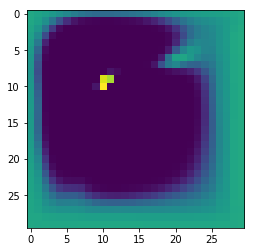

epoch 4750


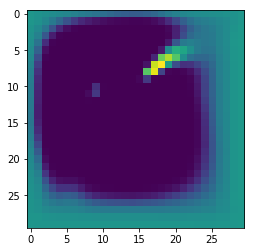

epoch 4800


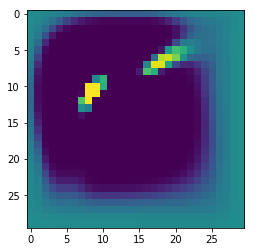

epoch 4850


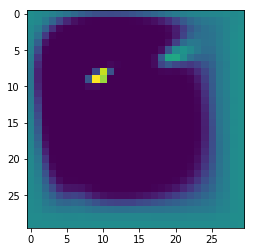

epoch 4900


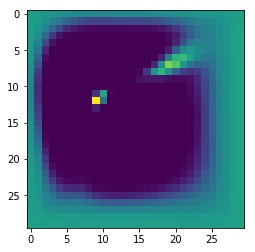

epoch 4950


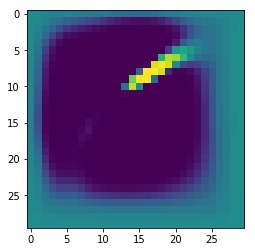

epoch 5000


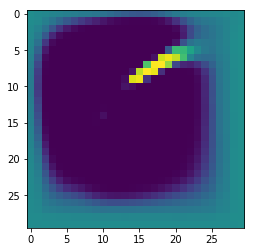

epoch 5050


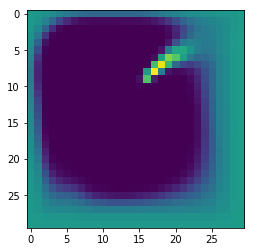

epoch 5100


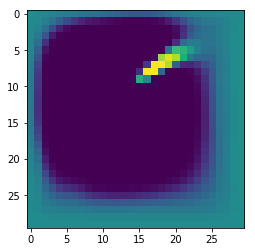

epoch 5150


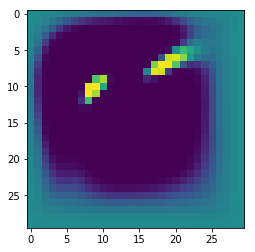

epoch 5200


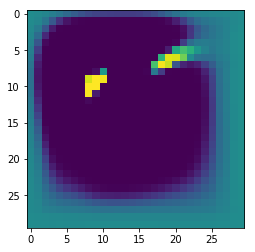

epoch 5250


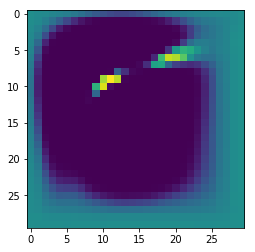

epoch 5300


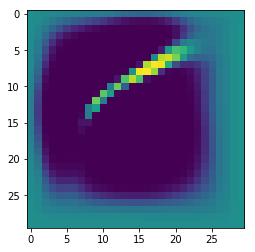

epoch 5350


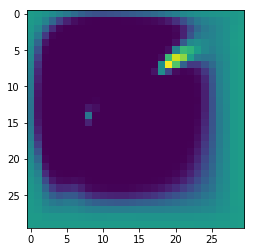

epoch 5400


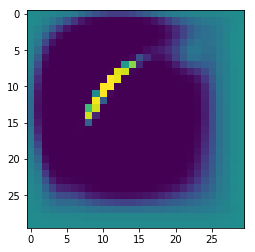

epoch 5450


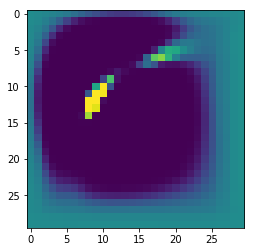

epoch 5500


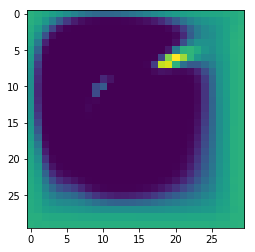

epoch 5550


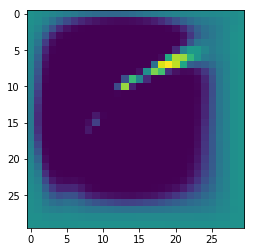

epoch 5600


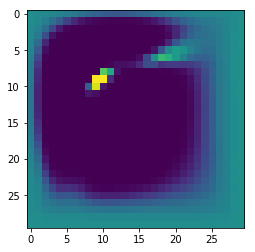

epoch 5650


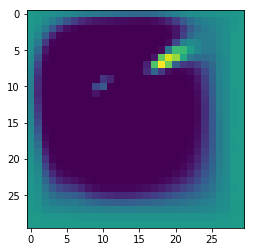

epoch 5700


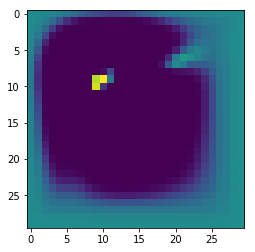

epoch 5750


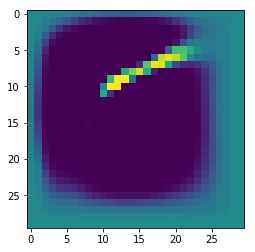

epoch 5800


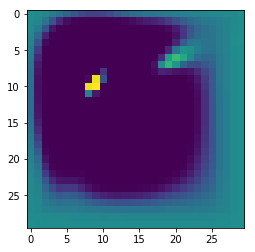

epoch 5850


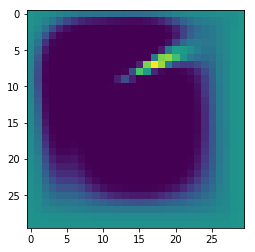

epoch 5900


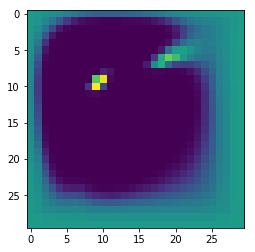

epoch 5950


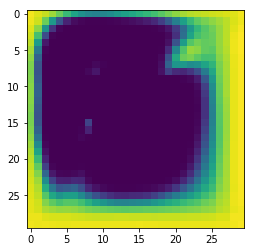

epoch 6000


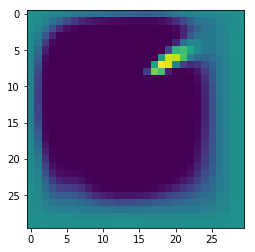

epoch 6050


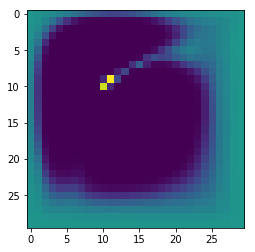

epoch 6100


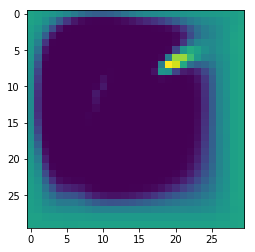

epoch 6150


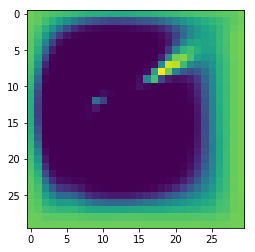

epoch 6200


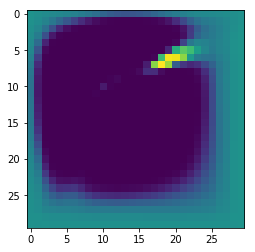

epoch 6250


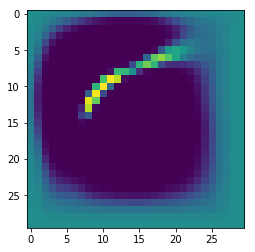

epoch 6300


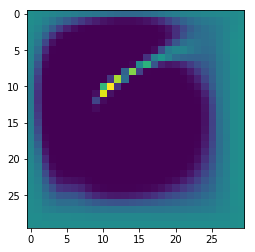

epoch 6350


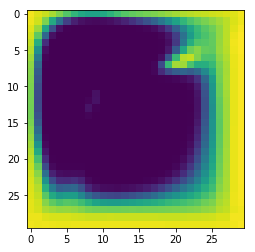

epoch 6400


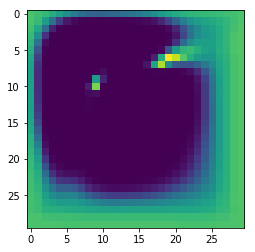

epoch 6450


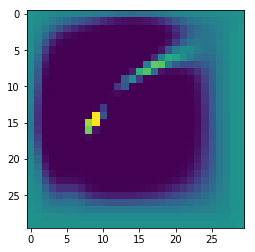

epoch 6500


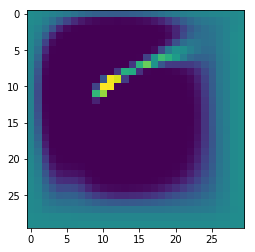

epoch 6550


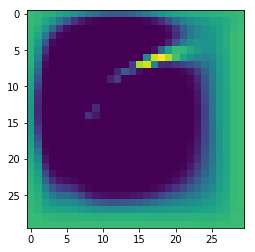

epoch 6600


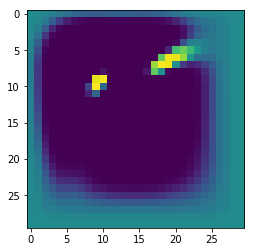

epoch 6650


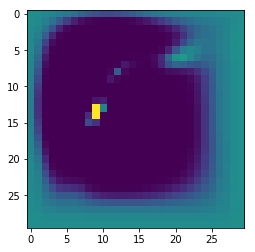

epoch 6700


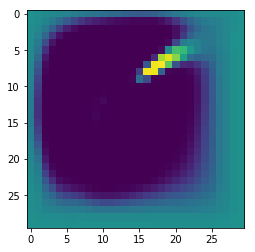

epoch 6750


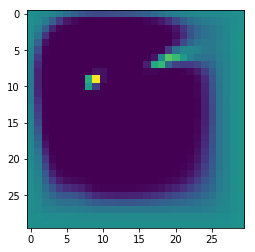

epoch 6800


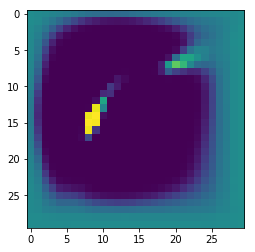

epoch 6850


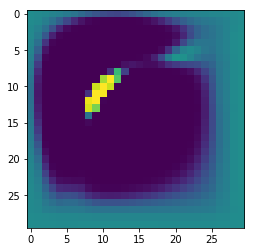

epoch 6900


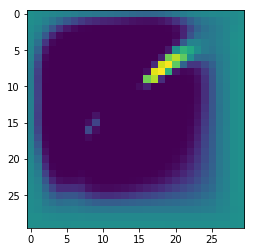

epoch 6950


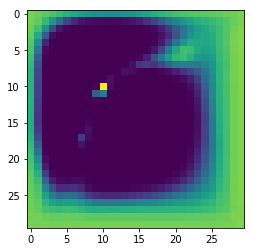

epoch 7000


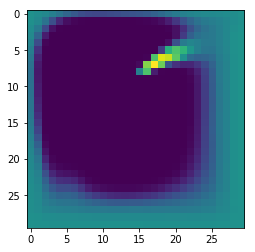

epoch 7050


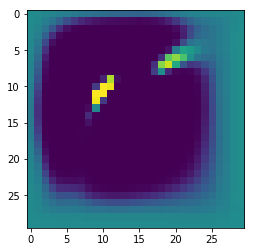

epoch 7100


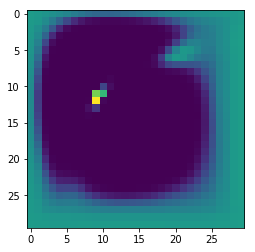

epoch 7150


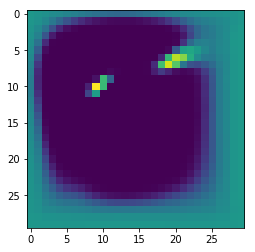

epoch 7200


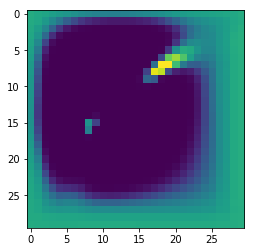

epoch 7250


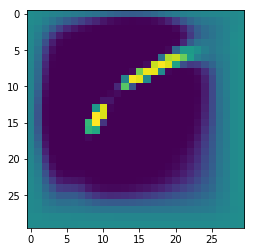

epoch 7300


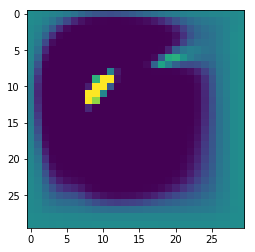

epoch 7350


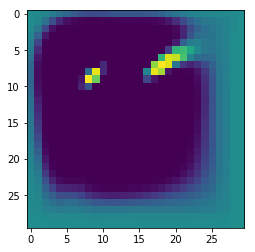

epoch 7400


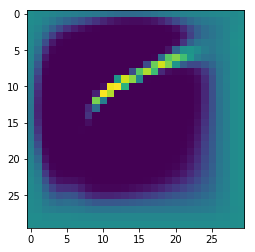

epoch 7450


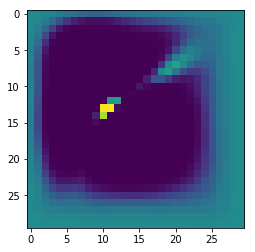

epoch 7500


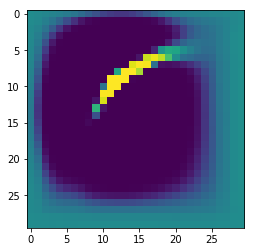

epoch 7550


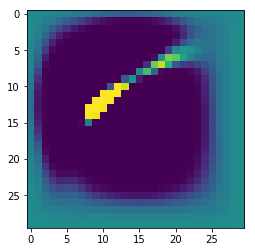

epoch 7600


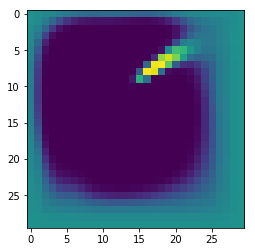

epoch 7650


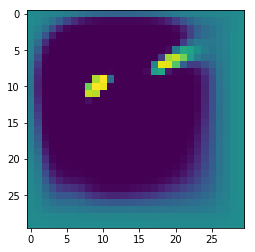

epoch 7700


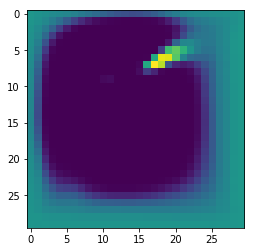

epoch 7750


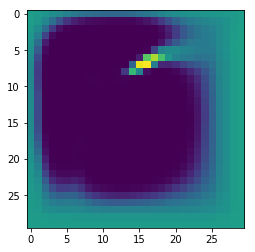

epoch 7800


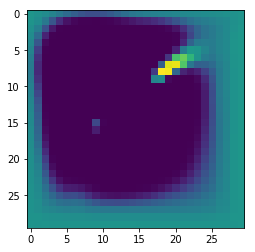

epoch 7850


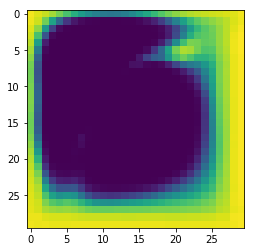

epoch 7900


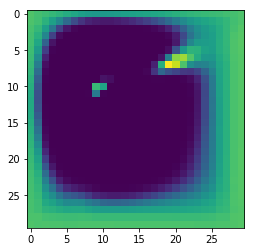

epoch 7950


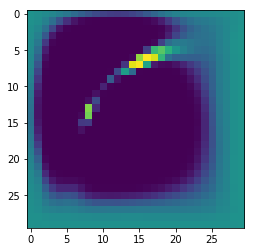

epoch 8000


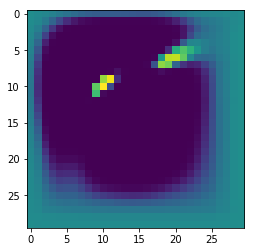

epoch 8050


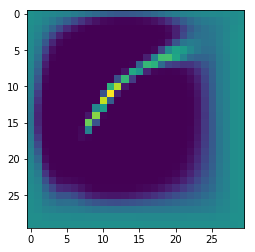

epoch 8100


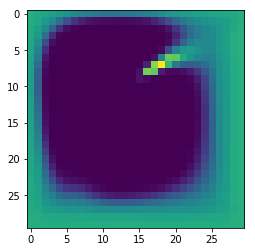

epoch 8150


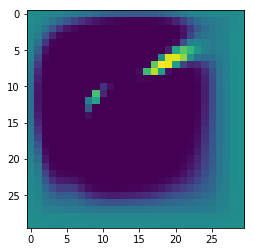

epoch 8200


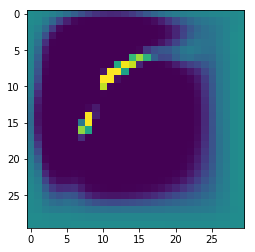

epoch 8250


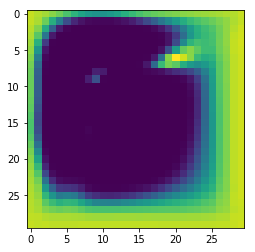

epoch 8300


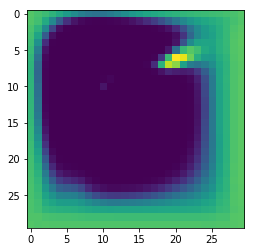

epoch 8350


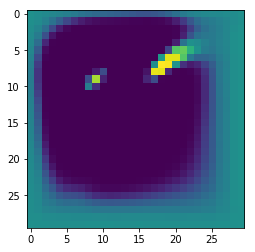

epoch 8400


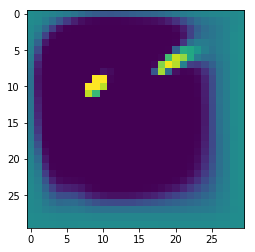

epoch 8450


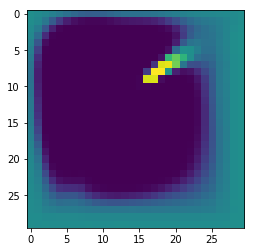

epoch 8500


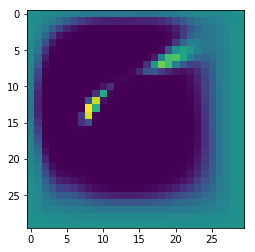

epoch 8550


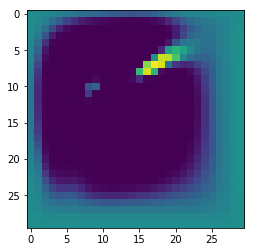

epoch 8600


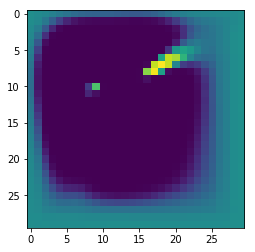

epoch 8650


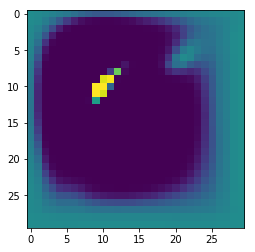

epoch 8700


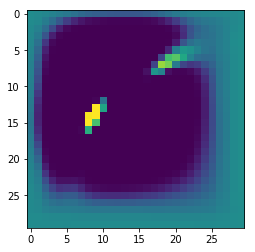

epoch 8750


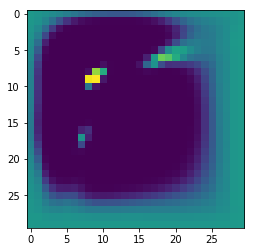

epoch 8800


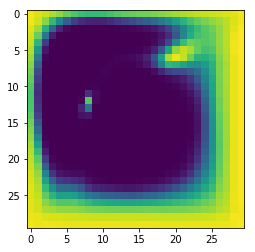

epoch 8850


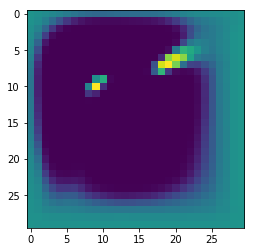

epoch 8900


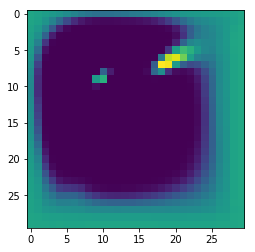

epoch 8950


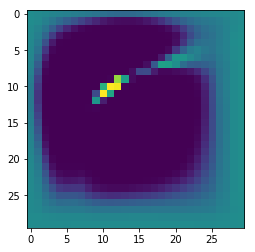

epoch 9000


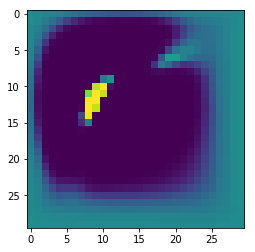

epoch 9050


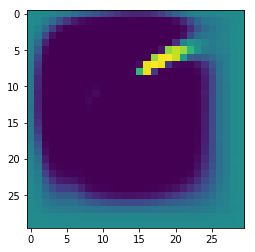

epoch 9100


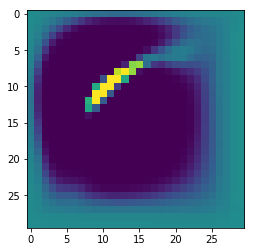

epoch 9150


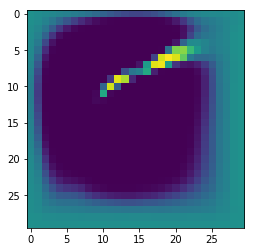

epoch 9200


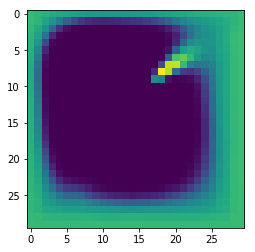

epoch 9250


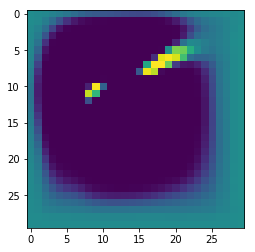

epoch 9300


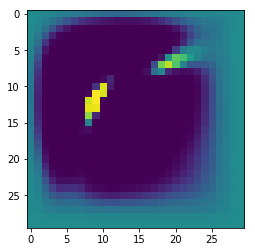

epoch 9350


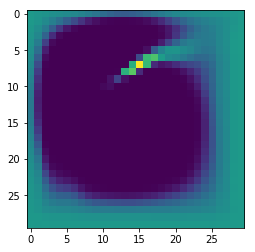

epoch 9400


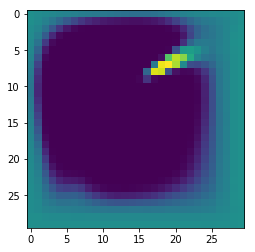

epoch 9450


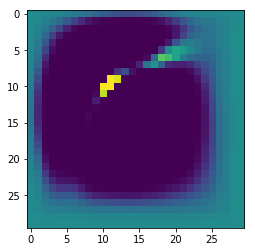

epoch 9500


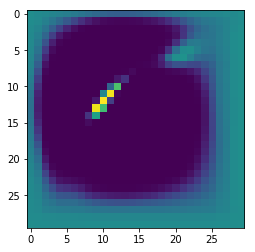

epoch 9550


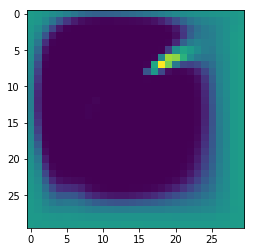

epoch 9600


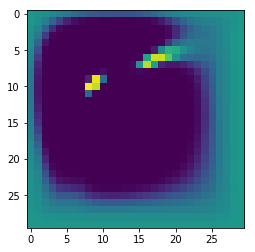

epoch 9650


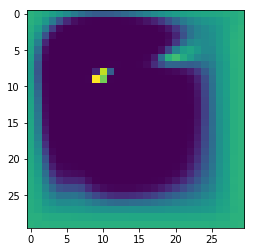

epoch 9700


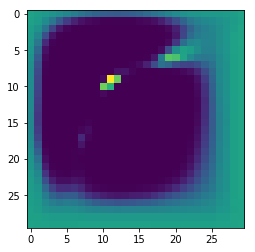

epoch 9750


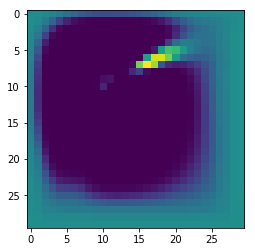

epoch 9800


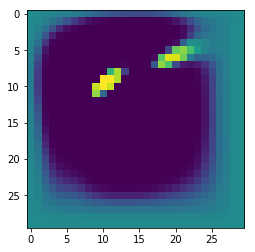

epoch 9850


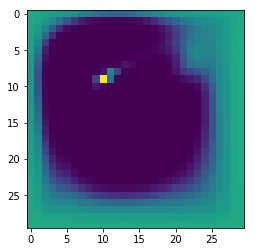

epoch 9900


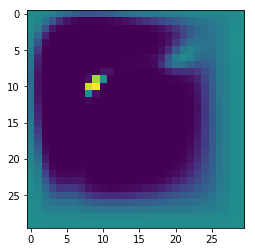

epoch 9950


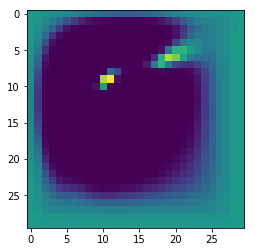

In [ ]:
class WGAN():
    def __init__(self):
        self.img_rows = 30
        self.img_cols = 30
        self.channels = 1

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        noise_shape = (100,)
        model = Sequential()

        model.add(Dense(10 * 10, input_shape=noise_shape))
        model.add(Activation('relu'))
        model.add(Reshape((10, 10, 1)))
        model.add(Deconv2D(128 , kernel_size=5, activation='relu'))
        model.add(Deconv2D(64, kernel_size=4))
        model.add(Activation('relu'))
        model.add(Deconv2D(64, kernel_size=4, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(32, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(32, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(16, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(16, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(1, kernel_size=3, activation='tanh'))

#        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(InputLayer(img_shape))
        model.add(Conv2D(32, kernel_size=4))
        model.add(LeakyReLU())
        model.add(Conv2D(32, kernel_size=4))
        model.add(LeakyReLU())
        model.add(AveragePooling2D(pool_size=2))
        model.add(Conv2D(64, kernel_size=4))
        model.add(LeakyReLU())
        model.add(Conv2D(64, kernel_size=3))
        model.add(LeakyReLU())
        model.add(AveragePooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('tanh'))
        model.add(Dense(2, activation=tf.nn.log_softmax))

#        model.summary()

        img = Input(shape=img_shape)
        features = model(img)
        valid = Dense(1, activation="linear")(features)

        return Model(img, valid)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Rescale -1 to 1
        X_train = tanh_data
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (half_batch, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, -np.ones((half_batch, 1)))
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.ones((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip discriminator weights
                for l in self.discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, -np.ones((batch_size, 1)))

            # Plot the progress
#            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
    def sample_images(self, epoch):
#        display.clear_output()
        print("epoch", epoch)
        noise = np.random.normal(0, 1, (1, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
#        fig, axs = plt.subplots(1, 1, figsize=(7,7))
        plt.imshow(gen_imgs[0, :,:,0])
        plt.show()
#        plt.close()


if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=25000, batch_size=32, sample_interval=50)

epoch 50


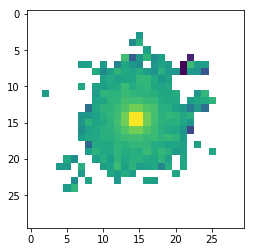

KeyboardInterrupt: 

In [17]:
class WGAN():
    def __init__(self):
        self.img_rows = 30
        self.img_cols = 30
        self.channels = 1

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        noise_shape = (100,)
        model = Sequential()

        model.add(Dense(10 * 10, input_shape=noise_shape))
        model.add(Activation('relu'))
        model.add(Reshape((10, 10, 1)))
        model.add(Deconv2D(128 , kernel_size=5, activation='relu'))
        model.add(Deconv2D(64, kernel_size=4))
        model.add(Activation('relu'))
        model.add(Deconv2D(64, kernel_size=4, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(32, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(32, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(16, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(16, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(1, kernel_size=3, activation='tanh'))

#        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(InputLayer(img_shape))
        model.add(Conv2D(32, kernel_size=4))
        model.add(LeakyReLU())
        model.add(Conv2D(32, kernel_size=4))
        model.add(LeakyReLU())
        model.add(AveragePooling2D(pool_size=2))
        model.add(Conv2D(64, kernel_size=4))
        model.add(LeakyReLU())
        model.add(Conv2D(64, kernel_size=3))
        model.add(LeakyReLU())
        model.add(AveragePooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('tanh'))
        model.add(Dense(2, activation=tf.nn.log_softmax))

#        model.summary()

        img = Input(shape=img_shape)
        features = model(img)
        valid = Dense(1, activation="linear")(features)

        return Model(img, valid)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Rescale -1 to 1
        X_train = tanh_data
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (half_batch, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, -np.ones((half_batch, 1)))
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.ones((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip discriminator weights
                for l in self.discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, -np.ones((batch_size, 1)))

            # Plot the progress
#            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
    def sample_images(self, epoch):
        display.clear_output()
        print("epoch", epoch)
        noise = np.random.normal(0, 1, (1, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
#        fig, axs = plt.subplots(1, 1, figsize=(7,7))
        plt.imshow(np.log(gen_imgs[0, :,:,0] * real_data_std + real_data_mean))
        plt.show()
#        plt.close()











if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=200, batch_size=32, sample_interval=50)

epoch 3950


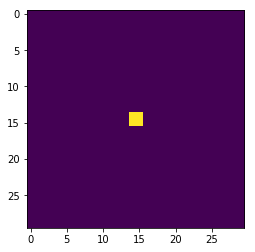

In [13]:
class WGAN():
    def __init__(self):
        self.img_rows = 30
        self.img_cols = 30
        self.channels = 1

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        noise_shape = (100,)
        model = Sequential()

        model.add(Dense(10 * 10, input_shape=noise_shape))
        model.add(Activation('relu'))
        model.add(Reshape((10, 10, 1)))
        model.add(Deconv2D(128 , kernel_size=5, activation='relu'))
        model.add(Deconv2D(64, kernel_size=4))
        model.add(Activation('relu'))
        model.add(Deconv2D(64, kernel_size=4, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(32, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(32, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(16, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(16, kernel_size=3, activation='relu'))
        model.add(Activation('relu'))
        model.add(Deconv2D(1, kernel_size=3, activation='tanh'))

#        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(InputLayer(img_shape))
        model.add(Conv2D(32, kernel_size=4))
        model.add(LeakyReLU())
        model.add(Conv2D(32, kernel_size=4))
        model.add(LeakyReLU())
        model.add(AveragePooling2D(pool_size=2))
        model.add(Conv2D(64, kernel_size=4))
        model.add(LeakyReLU())
        model.add(Conv2D(64, kernel_size=3))
        model.add(LeakyReLU())
        model.add(AveragePooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('tanh'))
        model.add(Dense(2, activation=tf.nn.log_softmax))

#        model.summary()

        img = Input(shape=img_shape)
        features = model(img)
        valid = Dense(1, activation="linear")(features)

        return Model(img, valid)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Rescale -1 to 1
        X_train = stand_real_data
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (half_batch, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, -np.ones((half_batch, 1)))
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.ones((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip discriminator weights
                for l in self.discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, -np.ones((batch_size, 1)))

            # Plot the progress
#            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
    def sample_images(self, epoch):
        display.clear_output()
        print("epoch", epoch)
        noise = np.random.normal(0, 1, (1, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
#        fig, axs = plt.subplots(1, 1, figsize=(7,7))
        plt.imshow(np.multiply(gen_imgs[0, :,:,0], real_data_std) + real_data_mean)
        plt.show()
#        plt.close()


if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=4000, batch_size=32, sample_interval=50)

##  improved wgan